# Binary VQE (package client)

This notebook formulates **asset selection** as a QUBO and solves it with a **Variational Quantum Eigensolver**.

### Problem

- Decision: $x_i \in \{0,1\}$ selects asset $i$.
- Objective (mean–variance with cardinality):

$$
\min_{x \in \{0,1\}^n}\; \lambda\, x^\top \Sigma x \;-\; \mu^\top x \;+\; \alpha\,(\mathbf{1}^\top x - K)^2
$$

where $\mu$ is expected returns, $\Sigma$ covariance, $K$ desired count, $\lambda$ risk aversion, $\alpha$ penalty.

### Outputs
- Convergence curve: energy vs iteration
- Inclusion probabilities: $p_i = \tfrac{1-\langle Z_i\rangle}{2}$
- Sampled bitstrings histogram
- Candidate portfolios: rounded, Top-K, mode, best-feasible sampled
- $\lambda$ sweep: inclusion probabilities + normalized weights
- Efficient frontier from Top-K projection

In [1]:
from __future__ import annotations

from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import draw_mpl

from vqe_portfolio.ansatz import binary_hwe_ry_cz_ring
from vqe_portfolio.binary import run_binary_vqe, binary_lambda_sweep
from vqe_portfolio.frontier import binary_frontier_from_probs
from vqe_portfolio.plotting import (
    plot_trace,
    bar_allocations,
    plot_lambda_sweep_bars,
    plot_frontier,
    savefig,
)
from vqe_portfolio.types import BinaryVQEConfig, LambdaSweepConfig
from vqe_portfolio.utils import set_global_seed, resolve_notebook_outdir

OUTDIR = resolve_notebook_outdir()

SEED = 0
set_global_seed(SEED)


## Toy data

In [2]:
mu = np.array([0.10, 0.20, 0.15, 0.12], dtype=float)

Sigma = np.array(
    [
        [0.005, -0.010, 0.004, -0.002],
        [-0.010, 0.040, -0.002, 0.004],
        [0.004, -0.002, 0.023, 0.002],
        [-0.002, 0.004, 0.002, 0.018],
    ],
    dtype=float,
)

n = len(mu)

# Objective params
LAM = 5.0
K = 2
ALPHA = 2.0

# VQE params
DEPTH = 2
STEPS = 75
STEPSIZE = 0.3
LOG_EVERY = 5

## Circuit Drawing

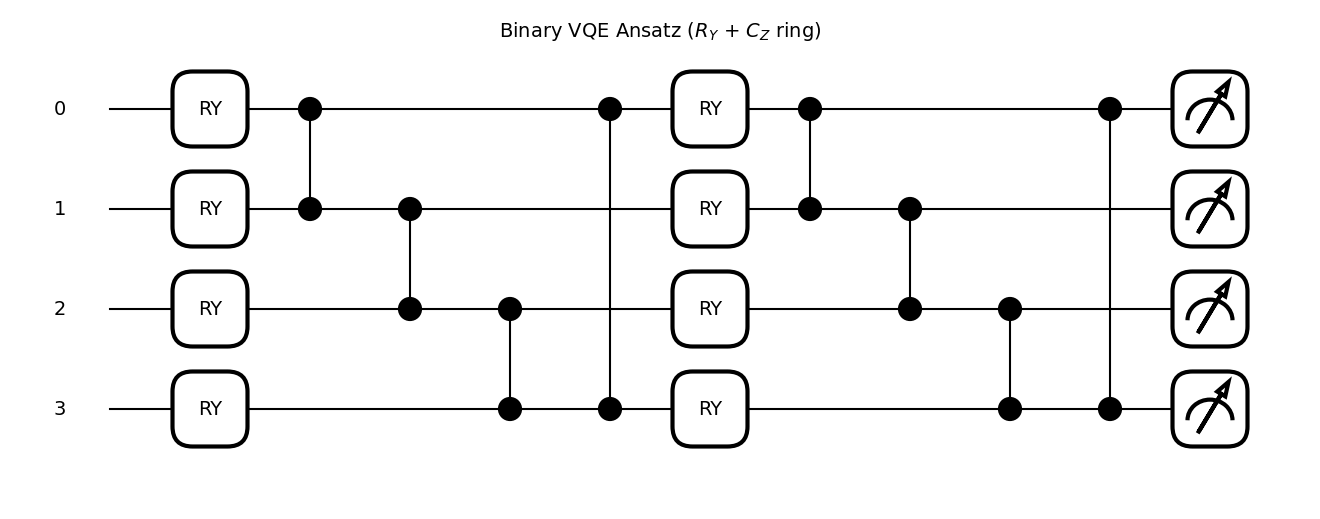

In [3]:
dev_preview = qml.device("default.qubit", wires=n, shots=None)


@qml.qnode(dev_preview, interface="autograd")
def circuit_preview(params: np.ndarray):
    binary_hwe_ry_cz_ring(params, depth=DEPTH, n_wires=n)
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]


demo_params = np.tile(np.linspace(0.0, np.pi / 2, n), (DEPTH, 1))
fig, ax = draw_mpl(circuit_preview)(demo_params)
fig.suptitle(r"Binary VQE Ansatz ($R_Y$ + $C_Z$ ring)", fontsize=14)
savefig(OUTDIR / "Binary_VQE_Circuit.png", dpi=300)
plt.show()

## Run Binary VQE (package entry point)

In [4]:
cfg = BinaryVQEConfig(
    depth=DEPTH,
    steps=STEPS,
    stepsize=STEPSIZE,
    log_every=LOG_EVERY,
    lam=LAM,
    alpha=ALPHA,
    k=K,
    device="default.qubit",
    shots_train=None,      # exact expectations during training
    shots_sample=2000,     # sampling after training
    seed=SEED,
)

res = run_binary_vqe(mu, Sigma, cfg)

/usr/local/python/3.12.1/lib/python3.12/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


### Convergence plot

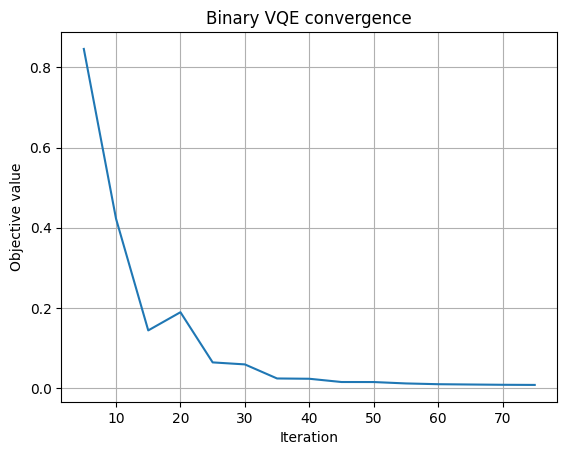

In [5]:
plot_trace(
    res.energy_trace.steps,
    res.energy_trace.values,
    xlabel="Iteration",
    ylabel="Objective value",
    title="Binary VQE convergence",
    outpath=OUTDIR / "Binary_VQE_Convergence.png",
)
plt.show()

## Inclusion probabilities, rounding, Top-K projection

In [6]:
x_prob = np.array(res.x_prob, dtype=float)
x_round = np.array(res.x_round, dtype=int)
x_topk = np.array(res.x_topk, dtype=int)

print("Expected x:", np.round(x_prob, 3))
print("Rounded x :", x_round.tolist(), " sum=", int(x_round.sum()))
print("Top-K x   :", x_topk.tolist(), " sum=", int(x_topk.sum()))

Expected x: [0.001 1.    0.043 0.957]
Rounded x : [0, 1, 0, 1]  sum= 2
Top-K x   : [0, 1, 0, 1]  sum= 2


### Bar plots: raw probabilities and normalized weights

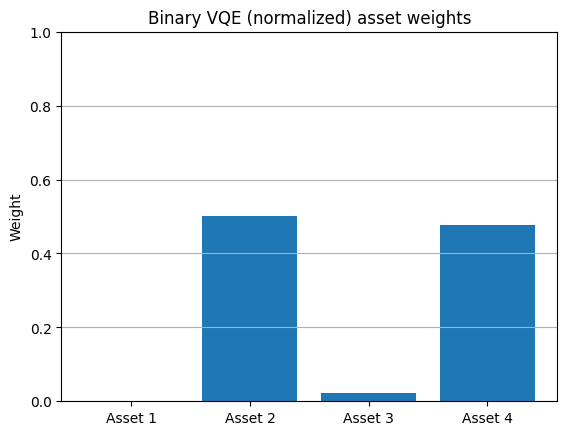

In [7]:
asset_labels = [f"Asset {i+1}" for i in range(n)]

# bar_allocations(
#     labels=asset_labels,
#     values=x_prob,
#     ylabel="Weight",
#     title="Binary VQE asset weights",
#     ylim=(0, 1),
#     outpath=OUTDIR / "Binary_VQE_Probabilities.png",
# )
# plt.show()

x_prob_norm = x_prob / (x_prob.sum() + 1e-12)
bar_allocations(
    labels=asset_labels,
    values=x_prob_norm,
    ylabel="Weight",
    title="Binary VQE (normalized) asset weights",
    ylim=(0, 1),
    outpath=OUTDIR / "Binary_VQE_Probabilities_Normalized.png",
)
plt.show()

## Sampling results

In [8]:
# res.sample_counts is a dict[tuple[int,...], int]
counts = Counter(res.sample_counts)

# Mode / best feasible according to package logic
x_mode = np.array(res.x_mode, dtype=int)
x_best_feasible = res.x_best_feasible

print("Most-frequent bitstring x:", x_mode.tolist(), " sum=", int(x_mode.sum()))
if x_best_feasible is None:
    print("No feasible (sum=K) sample found; best-feasible is None.")
else:
    print("Best-feasible sampled x:", x_best_feasible.tolist(), " sum=", int(x_best_feasible.sum()))

Most-frequent bitstring x: [0, 1, 0, 1]  sum= 2
Best-feasible sampled x: [1, 1, 0, 0]  sum= 2


### Histogram of sampled bitstrings

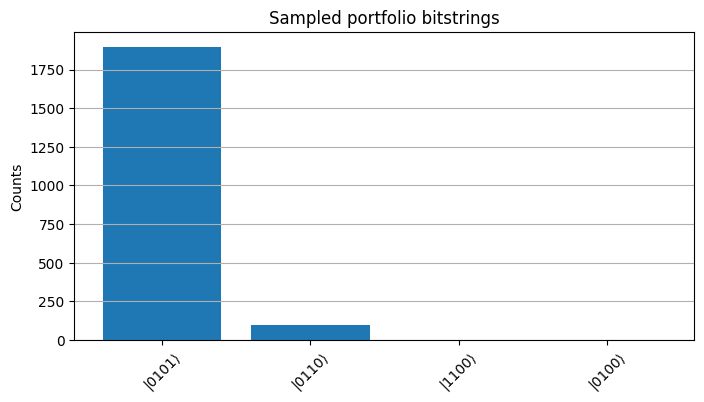

In [9]:
bitstrings = ["".join(map(str, bs)) for bs in counts.keys()]
frequencies = [counts[bs] for bs in counts.keys()]
labels = [f"|{b}⟩" for b in bitstrings]

plt.figure(figsize=(8, 4))
plt.bar(labels, frequencies)
plt.xticks(rotation=45)
plt.ylabel("Counts")
plt.title("Sampled portfolio bitstrings")
plt.grid(axis="y")
savefig(OUTDIR / "Binary_VQE_Portfolio_Bitstrings.png", dpi=300)
plt.show()

## λ sweep

In [10]:
lambdas = np.round(np.linspace(0.1, 5.0, 15, dtype=float), 2)

sweep_cfg = LambdaSweepConfig(
    lambdas=lambdas,
    steps_per_lambda=80,
    stepsize=0.2,
    warm_start=False,
)

res_sweep = binary_lambda_sweep(mu, Sigma, cfg, sweep_cfg)

probs = np.array(res_sweep.probs_by_lambda, dtype=float)  # (L, n)
lam_arr = np.array(res_sweep.lambdas, dtype=float)

### λ sweep plots (raw and normalized)

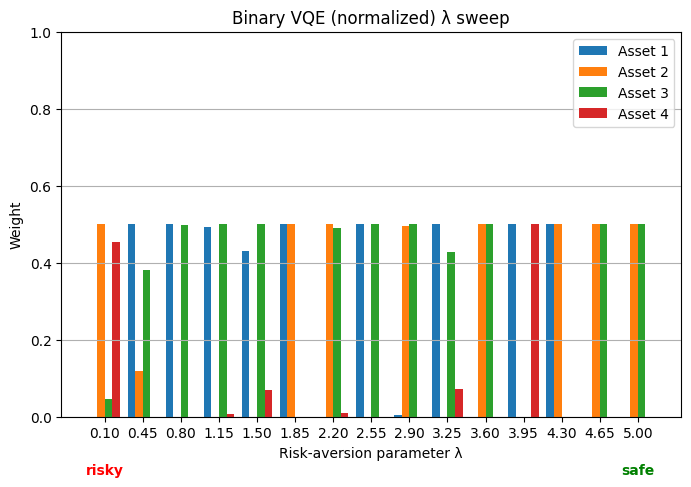

In [11]:
# plot_lambda_sweep_bars(
#     lambdas=lam_arr,
#     mat=probs,
#     asset_labels=asset_labels,
#     ylabel="Weight",
#     title="Binary VQE λ sweep",
#     outpath=OUTDIR / "Binary_VQE_Lambda_Sweep.png",
# )
# plt.show()

probs_norm = probs / (probs.sum(axis=1, keepdims=True) + 1e-12)
plot_lambda_sweep_bars(
    lambdas=lam_arr,
    mat=probs_norm,
    asset_labels=asset_labels,
    ylabel="Weight",
    title="Binary VQE (normalized) λ sweep",
    outpath=OUTDIR / "Binary_VQE_Lambda_Sweep_Normalized.png",
)
plt.show()

## Efficient frontier from λ sweep

- Project each λ point to **Top-K** selection by inclusion probabilities.
- Compute (σ, R) on the resulting vector (binary exposure by default).

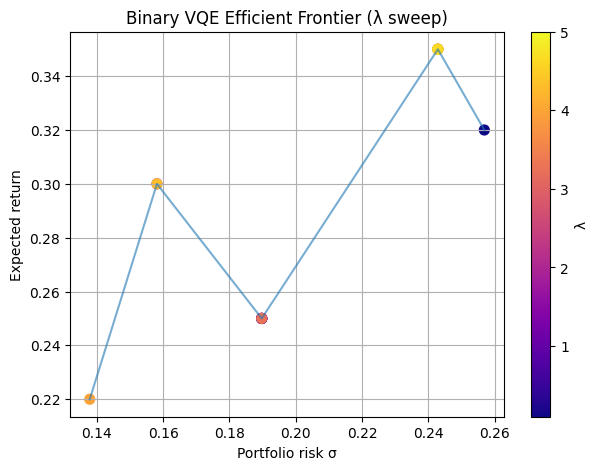

In [12]:
front = binary_frontier_from_probs(
    mu=mu,
    Sigma=Sigma,
    lambdas=lam_arr,
    probs_by_lambda=probs,
    k=K,
    equal_weight=False,
    sort_by="risk",
)

plot_frontier(
    risks=front.risks,
    returns=front.returns,
    lambdas_sorted=front.lambdas,
    title="Binary VQE Efficient Frontier (λ sweep)",
    outpath=OUTDIR / "Binary_VQE_Efficient_Frontier.png",
)
plt.show()